<a href="https://colab.research.google.com/github/TheRadDani/Adversarial-Training/blob/main/AdversarialTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are also several types of goals, including misclassification and source/target misclassification. A goal of misclassification means the adversary only wants the output classification to be wrong but does not care what the new classification is. A source/target misclassification means the adversary wants to alter an image that is originally of a specific source class so that it is classified as a specific target class.

## Fast Gradient Sign Attack (FGSM)

 The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, gradients.

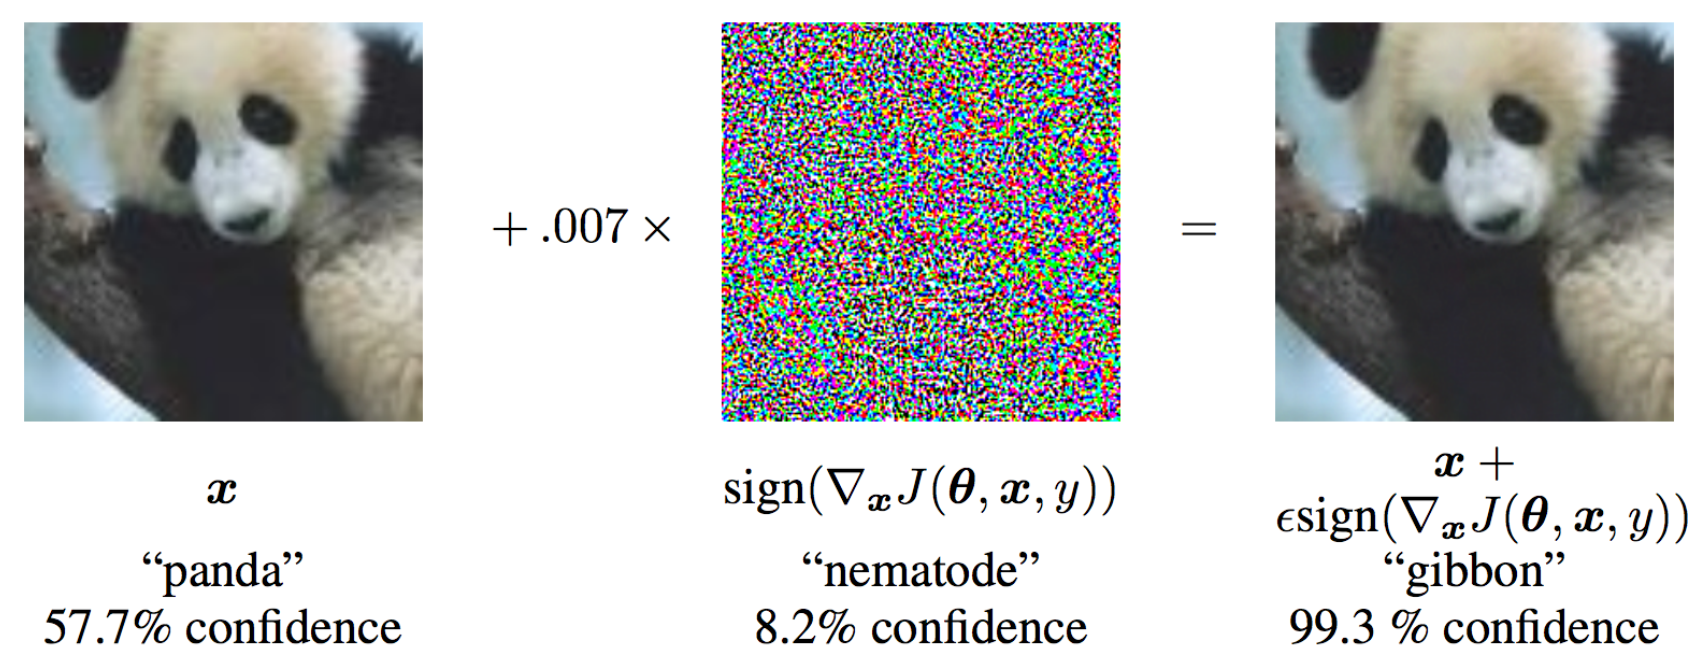

Rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data to maximize the loss based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./lenet_mnist_model.pth.pt"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Model for clasification
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

Check if parameters for the data are normal

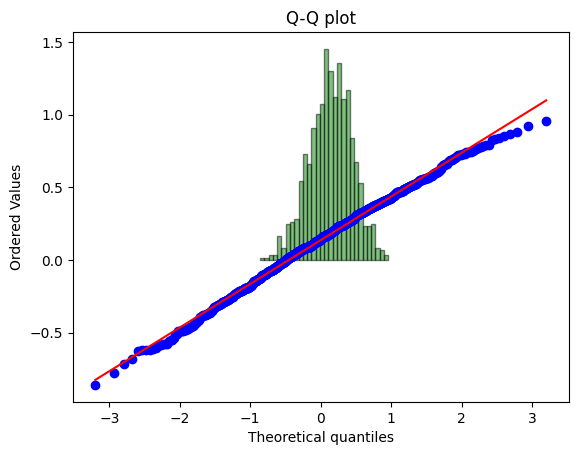

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Given mean and standard deviation
mean = 0.1307
std = 0.3081

# Generate random samples from a normal distribution
data = np.random.normal(loc=mean, scale=std, size=1000)

# Histogram
plt.hist(data, bins=30, density=True, alpha=0.5, color='g', edgecolor='black')

# Q-Q plot
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q plot')

plt.show()

In [ ]:
transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, download=True, transform=transform)
)

batch_size=1
shuffle=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#initialize the Network
model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location=device))

model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

FGSM Attack

data_grad is gradient of the loss w.r.t the input image ∇ₓ J(θ,x,y).

In [ ]:
# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
  # Collect element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307],std=[0.081]):
  """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
  """

  if isinstance(mean, list):
    mean = torch.tensor(mean).to(device)
  if isinstance(std, list):
    std = torch.tensor(std).to(device)

  return batch * std.view(1, -1, 1, 1) +  mean.view(1, -1, 1, 1)

In [ ]:
def test(model, device, test_loader, epsilon):

  # Accuracy counter
  correct = 0
  adv_examples = []

  # Loop over all examples in test set
  for data, target in test_loader:
    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    # If the initial prediction is wrong, don't bother attacking, just move on
    if init_pred.item() != target.item():
      continue
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect ``datagrad``
    data_grad = data.grad.data

    # Restore the data to its original scale
    data_denorm = denorm(data)

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

    # Reapply normalization
    perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

    # Re-classify the perturbed image
    output = model(perturbed_data_normalized)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    if final_pred.item() == target.item():
      correct += 1
      # Special case for saving 0 epsilon examples
      if epsilon == 0 and len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(test_loader))
  print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

for eps in epsilons:
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

Epsilon: 0	Test Accuracy = 9095 / 10000 = 0.9095
Epsilon: 0.05	Test Accuracy = 1852 / 10000 = 0.1852
Epsilon: 0.1	Test Accuracy = 983 / 10000 = 0.0983
Epsilon: 0.15	Test Accuracy = 920 / 10000 = 0.092
Epsilon: 0.2	Test Accuracy = 906 / 10000 = 0.0906
Epsilon: 0.25	Test Accuracy = 1023 / 10000 = 0.1023
Epsilon: 0.3	Test Accuracy = 1212 / 10000 = 0.1212


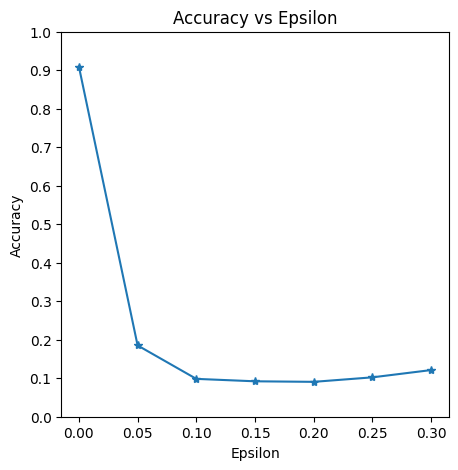

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

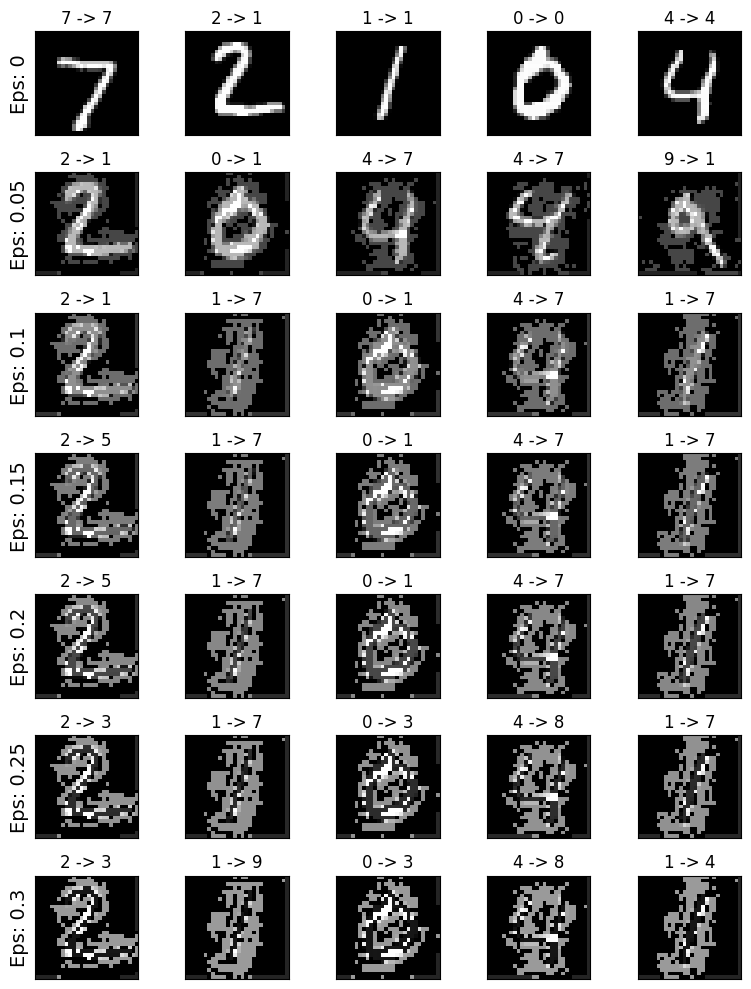

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()